# Plot RCM domains

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import xarray as xr
from shapely.geometry import Polygon

Projection of the final plot

In [2]:
proj = ccrs.LambertConformal(central_longitude=4.8, central_latitude=46.2, standard_parallels=[46.2, 46.2])

Other items to show

In [3]:
minimal_domain = np.array([1, 17, 40, 50]) # ALP-3i
cities_demonstrator = ['Paris', 'Barcelona', 'Prague', 'Bergen']
cities_additional = ['Hamburg', 'Newcastle upon Tyne', 'Copenhagen']

In [4]:
def get_interior_borders(orog_file, dist=10):
  ds = xr.load_dataset(orog_file)
  lonsm = ds['lon'].values
  latsm = ds['lat'].values
  ix = dist
  rval = []
  for iy in range(latsm.shape[0])[dist:-dist]:
    rval.append((lonsm[iy,ix], latsm[iy,ix]))
  iy = len(latsm)-dist
  for ix in range(latsm.shape[1])[dist:-dist]:
    rval.append((lonsm[iy,ix], latsm[iy,ix]))
  ix = len(latsm[0])-dist
  for iy in range(latsm.shape[0]-1,0,-1)[dist:-dist]:
    rval.append((lonsm[iy,ix], latsm[iy,ix]))
  iy = dist
  for ix in range(latsm.shape[1]-1,0,-1)[dist:-dist]:
    rval.append((lonsm[iy,ix], latsm[iy,ix]))
  return(Polygon(rval))

def plot_domain(axis, orog_file, color, relax):
  boundaries = get_interior_borders(orog_file, relax)
  axis.add_geometries([boundaries], crs=lonlat, linewidth=1.5, facecolor='none', edgecolor=color, zorder=3)
  # manually add labels
  proxy_artist.append(mpatches.Rectangle((0,0),1,0.1, linewidth=1, facecolor='none', edgecolor=color))

def plot_minimal(axis, minimal_lonlat, color='red', alpha=0.2):
  '''Minimal domain in regular lon-lat coords as shade'''
  domain_size_deg = minimal_lonlat[1::2]-minimal_lonlat[::2]
  axis.add_patch(mpatches.Rectangle(
    xy=minimal_lonlat[::2], width=domain_size_deg[0], height=domain_size_deg[1],
    facecolor=color, alpha=alpha, transform=lonlat
  ))
  proxy_artist = [mpatches.Rectangle((0,0),1,0.1, facecolor=color, alpha=alpha)]
  return(proxy_artist)
    
def plot_cities(axis, names, **kwargs):
  city_info = pd.read_csv(
    'https://raw.githubusercontent.com/FPS-URB-RCC/CORDEX-CORE-WG/no-gp022-filter/city_info.csv',
    comment='#', dtype = dict(domain = 'category', ktype = 'category')
  )
  for city in names:
    citydf = city_info.query(f'city == "{city}"')
    axis.plot(citydf['lon'].values,citydf['lat'].values, zorder=3, linestyle='', transform=lonlat, **kwargs)

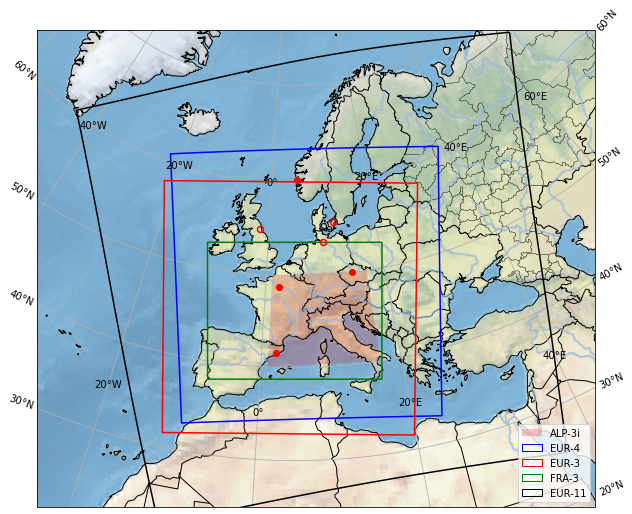

In [5]:
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1, 1, 1, projection=proj)
lonlat = ccrs.PlateCarree()
ax.set_extent([-25, 40, 25, 73], crs=lonlat)
ax.stock_img()
ax.gridlines(draw_labels=True)
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1)
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.25)
ax.add_feature(cfeature.RIVERS.with_scale('50m'), linewidth=2, alpha=0.7)
proxy_artist = plot_minimal(ax, minimal_domain)

col = {'EUR-4': 'blue', 'EUR-3': 'red', 'FRA-3': 'green'}
doms = col.keys()
for dom in doms:
  plot_domain(ax, f'data/orog_{dom}-d01_fx.nc', col[dom], 20)
# EUR-11
plot_domain(ax, f'data/orog_EUR-11-d01_fx.nc', 'black', 10)
ax.legend(proxy_artist, ['ALP-3i']+list(doms)+['EUR-11'], loc='lower right', fancybox=True)
plot_cities(ax, cities_demonstrator, marker='o', color='r')
plot_cities(ax, cities_additional, marker='o', color='r', mfc='none', mew=1.5)
plt.show()